## Evaluation with human judgements from SimpEval

In [1]:
import pickle
import pandas as pd
import os
import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
from labeling_functions import get_all_lfs

from pandarallel import pandarallel
pandarallel.initialize()

from functools import lru_cache

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

import warnings

# Metrics
from evaluate import load
sari = load("sari")

from usb_utils import bertscore
import textstat
fkgl = textstat.flesch_kincaid_grade

# MPIRE
from usb_utils import mpire_score


/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


resources get initialised


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# BATS models
from bats_label_model import BatsModel
model_nns   = BatsModel("NNSeval-1249")

100%|██████████| 100/100 [00:07<00:00, 12.71epoch/s]
/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


In [3]:
model_nns.get_classifier()

RandomForestClassifier(random_state=42)

In [4]:
model_nns.simp_labels[0].shape

(1249,)

In [54]:
def calc_score(input_str, model=model_nns):
    sel_indices = np.array(model.lfs_vec).nonzero()[0]
    try:
        opt_X = np.take(model.transform_to_bin_vec(input_str), sel_indices)
        return model.classifier.predict_proba(np.array([opt_X]))[0][0]
    except:
        return np.NaN 


In [47]:
calc_score("1 2 .")

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [34]:
# Datasets

# Datasets preprocessed by Christin
from load_simplicity import load_asset_ds
from load_simplicity import load_metaeval_ds
from load_simplicity import load_questeval_ds
from load_simplicity import load_simpeval_ds

asset_simp = load_asset_ds()
metaeval_simp = load_metaeval_ds()
questeval_simp = load_questeval_ds()
simpeval_simp = load_simpeval_ds() # << Includes metaeval DA

# Loading DA data from original source Simplicity-DA (https://github.com/feralvam/metaeval-simplification/tree/main)

df_SimplicityDA_texts = pd.read_csv("/workspace/datasets/Simplicity-DA/simplicity_DA.csv")

# select DA split for "full" >> 600 texts 
df_SimplicityDA_metrics = pd.read_csv("/workspace/datasets/Simplicity-DA/metrics_simplicity_DA.csv")
df_SimplicityDA_metrics = df_SimplicityDA_metrics.loc[df_SimplicityDA_metrics["test_set"] == "asset"]

df_SimplicityDA_metrics_full = pd.read_csv("/workspace/datasets/Simplicity-DA/metrics_simplicity_DA.csv")

# merge texts with human labels and metrics
df_SimplicityDA = pd.merge(df_SimplicityDA_texts, df_SimplicityDA_metrics)


In [58]:
test_df = simpeval_simp.loc[simpeval_simp["inner_ds"] == "simplicity_DA"][:100]

In [59]:
test_df["NNS_model_score_simp"] = test_df.progress_apply(lambda row: calc_score(row["simp"]), axis = 1)
test_df["NNS_model_score_src"] = test_df.progress_apply(lambda row: calc_score(row["src"]), axis = 1)

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


<Axes: xlabel='simplicityScore', ylabel='NNS_model_score_simp'>

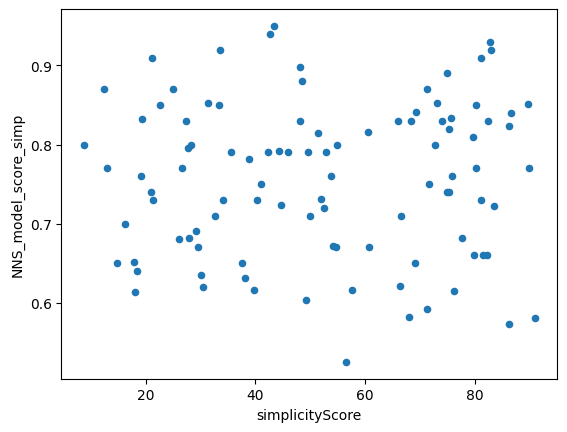

In [60]:
test_df.plot.scatter("simplicityScore", "NNS_model_score_simp")

In [62]:
stats.spearmanr(test_df["simplicityScore"].to_list(), test_df["NNS_model_score_simp"].to_list())

SignificanceResult(statistic=0.056447307984045056, pvalue=0.5769664087276576)

In [56]:
test_df

,ds_id,src,simp,simplicityScore,origin,inner_ds,references,NNS_model_score_simp,NNS_model_score_src
0,SimpEval_22,Prunk is a member of Institute of European His...,Prunk is a member of Institute of European His...,71.333333,NeuralSeq2Seq,simplicity_DA,[Prunk is a member of Institute of European Hi...,0.870000,0.770000
1,SimpEval_22,"In return, Rollo swore fealty to Charles, conv...","In return, Rollo swore fealty to Charles, conv...",90.933333,SBMT,simplicity_DA,"[In return, Rollo swore loyalty to Charles and...",0.580000,0.453333
2,SimpEval_22,From 1900 to 1920 many new facilities were con...,From 1900 to 1920 many new plants were built o...,53.800000,SBMT,simplicity_DA,"[Between 1900 and 1920, many new buildings wer...",0.760000,0.661111
3,SimpEval_22,Mercury is similar in appearance to the Moon: ...,Mercury is similar in appearance to the Moon: ...,71.600000,PBMT,simplicity_DA,[Mercury looks like the Moon. It has many crat...,0.750000,0.815924
4,SimpEval_22,"He settled in London, devoting himself chiefly...","He settled in London, devoting himself.",27.733333,Semantics+PBMT,simplicity_DA,"[He settled in London, devoting himself practi...",0.795909,0.755909
5,SimpEval_22,The plant is considered a living fossil.,The plant is thought to be a living fossil.,66.600000,NeuralSeq2Seq,simplicity_DA,"[Plants are living fossils., The plan is regar...",0.710000,0.750833
6,SimpEval_22,Name Arzashkun seems to be the Assyrian form o...,Name Arzashkun seems to be the Assyrian form o...,20.933333,NeuralSeq2Seq,simplicity_DA,[Name Arzashkum seems to be the Assyrian form ...,0.740000,0.802222
7,SimpEval_22,"Brunstad has several fast food restaurants, a ...",Brunstad has a number of fast food restaurants...,73.066667,SBMT,simplicity_DA,"[Brunstad has several fast food restaurants, a...",0.852222,0.740342
8,SimpEval_22,"Prospectors from California, Europe and China ...","In California, Europe and China were also digg...",35.533333,NeuralSeq2Seq,simplicity_DA,"[Lawyers from California, Europe and China wer...",0.790000,0.760000
9,SimpEval_22,"Alessandro (""Sandro"") Mazzola (born 8 November...",Sandro Mazzola (born 8 November 1942) is a for...,72.800000,PBMT,simplicity_DA,"[Alessandro (""Sandro"") Mazzola is a former Ita...",0.800000,0.790000


## new evaluation with Simplicity-DA data and computed metrics

In [5]:
# calculate naive scores for DA dataset
# done in 3 splits with dumps because memory is sparse, you know. Gotta do what you gotta do.


texts = df_SimplicityDA["simp_sent"].to_list()
ts1 = texts[:200]
ts2 = texts[200:400]
ts3 = texts[400:]

res = []
for t in tqdm(ts1):
    try:
        res.append((-1*(model_wiki.calc_naive_score(t))+1)*100)
    except:
        print(f"{t} >> did not work.")
        res.append(30)

pickle.dump(res, open("temp_scores.pkl", "wb"))

res = []
for t in tqdm(ts2):
    try:
        res.append((-1*(model_wiki.calc_naive_score(t))+1)*100)
    except:
        print(f"{t} >> did not work.")
        res.append(30)

res = pickle.load(open("temp_scores.pkl", "rb")) + res
pickle.dump(res, open("temp_scores.pkl", "wb"))

res = []
for t in tqdm(ts3):
    try:
        res.append((-1*(model_wiki.calc_naive_score(t))+1)*100)
    except:
        print(f"{t} >> did not work.")
        res.append(0.3)

res = pickle.load(open("temp_scores.pkl", "rb")) + res
pickle.dump(res, open("temp_scores.pkl", "wb"))

df_SimplicityDA["BATS"] = res

In [62]:
# BATS scores for chosen model, if memery is sufficient

# select model here
chosen_model = model

# BATS model
df_SimplicityDA["BATS"] = df_SimplicityDA.progress_apply(lambda row: (-1*(chosen_model.calc_naive_score(row["simp_sent"]))+1)*100, axis = 1)

# BATS complex model
df_SimplicityDA["BATS_complex"] = df_SimplicityDA.progress_apply(lambda row: (-1*(chosen_model.calc_naive_score(row["orig_sent"]))+1)*100, axis = 1)

# BAT classification src
df_SimplicityDA["BATS_label_src"] = df_SimplicityDA.progress_apply(lambda row: (chosen_model.calc_score(row["orig_sent"])), axis = 1)

# BAT classification simp   
df_SimplicityDA["BATS_label_simp"] = df_SimplicityDA.progress_apply(lambda row: (chosen_model.calc_score(row["simp_sent"])), axis = 1)

# Pickle calculations
df_SimplicityDA.to_pickle("/workspace/datasets/Simplicity-DA/df_simp_da.pkl")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.43it/s]
/tmp/ipykernel_43145/2341442679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SimplicityDA_subset["BATS"] = df_SimplicityDA_subset.progress_apply(lambda row: (-1*(model_evalsplit.calc_naive_score(row["simp_sent"]))+1)*100, axis = 1)
100%|██████████| 100/100 [00:04<00:00, 22.95it/s]
/tmp/ipykernel_43145/2341442679.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SimplicityDA_subset["BATS_complex"] = df_SimplicityDA_subset.progress_apply(lambda 

## Scatterplots

<Axes: xlabel='simplicity', ylabel='sari'>

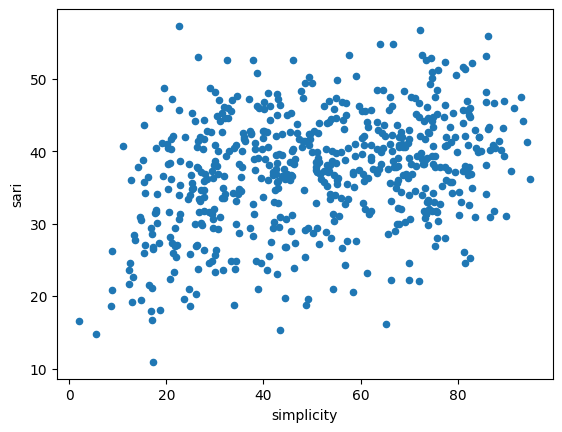

In [12]:
df_SimplicityDA.plot.scatter("simplicity", "sari")

<Axes: xlabel='simplicity', ylabel='BATS'>

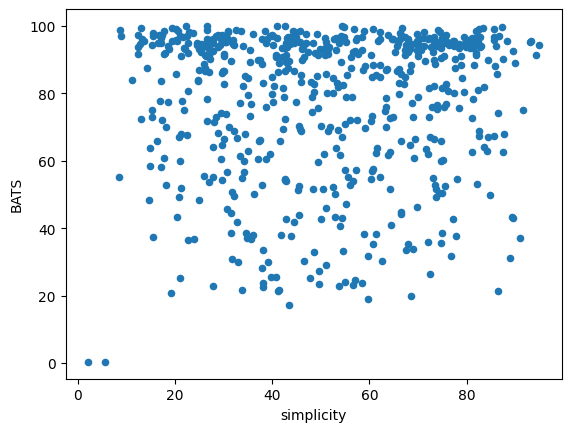

In [24]:
df_SimplicityDA.plot.scatter("simplicity", "BATS")

<Axes: xlabel='simplicity', ylabel='BATS'>

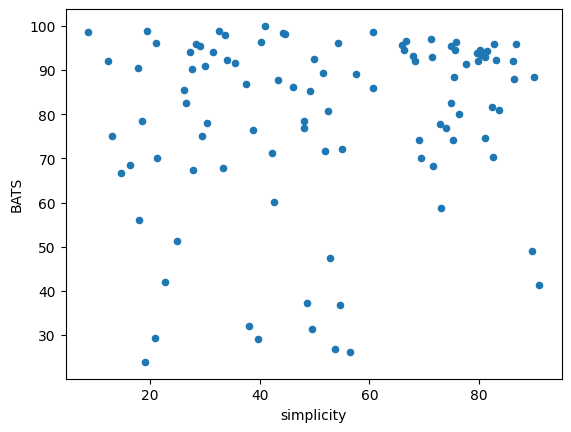

In [63]:
df_SimplicityDA_subset.plot.scatter("simplicity", "BATS")

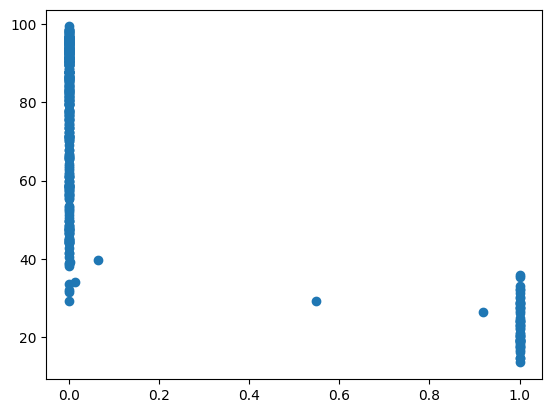

In [98]:
x = np.array(df_simpeval["BATS_label_simp"].to_list())
y = np.array(df_simpeval["BATS"].to_list())

plt.scatter(x, y)
plt.show()

In [ ]:
x = np.array(df_simpeval["BATS_label_src"].to_list())
y = np.array(df_simpeval["BATS_complex"].to_list())

plt.scatter(x, y)
plt.show()

## Correlation tests

In [29]:
pearson_r = {"simpeval_DA": 
{"BERTscore":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["bertscore_F1"].to_list()), 
"sari":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["sari"].to_list()), 
"samsa":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["samsa"].to_list()), 
"bleu":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["bleu"].to_list()), 
"BATSnaive_simple":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["BATS"].to_list()), 
"BATSnaive_original":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["BATS_complex"].to_list()), 
"BATS_label_simp":stats.pearsonr(df_SimplicityDA["simplicityScore"].to_list(), df_SimplicityDA["BATS_label_simp"].to_list()), 
"fkgl":stats.pearsonr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["fkgl"].to_list())}
}

spearman_r = {"simpeval_DA": 
{"BERTscore":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["bertscore_F1"].to_list()), 
"sari":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["sari"].to_list()), 
"samsa":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["samsa"].to_list()), 
"BATSnaive_simple":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["BATS"].to_list()), 
"BATSnaive_original":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["BATS_complex"].to_list()), 
"BATS_label_simp":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["BATS_label_simp"].to_list()), 
"fkgl":stats.spearmanr(df_SimplicityDA["simplicity"].to_list(), df_SimplicityDA["fkgl"].to_list())}
}

## Further Evaluation

In [ ]:
# check, how often BATS naive score rated the simplification as simpler than original:
pos = 0
neg = 0
for i, row in df_simpeval.iterrows():
    if row["BATS"] > row["BATS_complex"]:
        pos += 1
    else:
        neg += 1

print(pos,neg)

## Checking weights for LF Clusters

In [7]:
from pruning_lfs import prune_lfs as pruner

In [8]:
lfs = pruner()

/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])


In [9]:
# comparing automatic and manual clusters
cluster_manual = pickle.load(open("/workspace/datasets/clustering_manual_LFs.pkl", "rb"))
cluster_automatic = pickle.load(open("/workspace/datasets/auto_cluster_dic.pkl", "rb"))

auto = []
manual = []

for k in cluster_manual.keys():
    auto.append(cluster_automatic[k])
    manual.append(cluster_manual[k])
    print(k,auto[-1], manual[-1])


lf_words_cnt_wcount=15_SIMPLE 0 0
lf_words_cnt_wcount=16_SIMPLE 0 0
lf_words_cnt_wcount=17_SIMPLE 0 0
lf_words_cnt_wcount=18_SIMPLE 0 0
lf_words_cnt_wcount=19_SIMPLE 2 0
lf_words_cnt_wcount=20_SIMPLE 2 0
lf_words_cnt_wcount=21_SIMPLE 2 0
lf_words_cnt_wcount=22_SIMPLE 2 0
lf_words_cnt_wcount=23_SIMPLE 2 0
lf_words_cnt_wcount=24_SIMPLE 2 0
lf_words_cnt_wcount=20_NOT_SIMPLE 1 0
lf_words_cnt_wcount=21_NOT_SIMPLE 1 0
lf_words_cnt_wcount=22_NOT_SIMPLE 1 0
lf_words_cnt_wcount=23_NOT_SIMPLE 1 0
lf_words_cnt_wcount=24_NOT_SIMPLE 1 0
lf_words_cnt_wcount=25_NOT_SIMPLE 1 0
lf_words_cnt_wcount=26_NOT_SIMPLE 1 0
lf_words_cnt_wcount=27_NOT_SIMPLE 1 0
lf_words_cnt_wcount=28_NOT_SIMPLE 1 0
lf_words_cnt_wcount=29_NOT_SIMPLE 0 0
lf_words_cnt_wcount=30_NOT_SIMPLE 0 0
lf_words_cnt_wcount=31_NOT_SIMPLE 0 0
lf_words_cnt_wcount=32_NOT_SIMPLE 0 0
lf_words_cnt_wcount=33_NOT_SIMPLE 0 0
lf_words_cnt_wcount=34_NOT_SIMPLE 0 0
lf_words_cnt_wcount=35_NOT_SIMPLE 0 0
lf_words_cnt_wcount=36_NOT_SIMPLE 0 0
lf_words_cnt_w

In [11]:
model_lf_weights_brit = {}
for i, weight in enumerate(model_brit.label_model.get_weights()):
    model_lf_weights_brit[lf_names[i]] = weight

NameError: name 'model_brit' is not defined

In [106]:
model_lf_weights_wiki = {}
for i, weight in enumerate(model_wiki.label_model.get_weights()):
    model_lf_weights_wiki[lf_names[i]] = weight

In [110]:
model_lf_weights = {}
for i, weight in enumerate(model.label_model.get_weights()):
    model_lf_weights[lf_names[i]] = weight

In [126]:
cluster_weights = {}
for v in set(cluster_manual.values()):
    cluster_weights[v] = []

for k in cluster_manual.keys():
    cluster_weights[cluster_manual[k]].append(model_lf_weights[k])

# wiki 
cluster_weights_wiki = {}
for v in set(cluster_manual.values()):
    cluster_weights_wiki[v] = []

for k in cluster_manual.keys():
    cluster_weights_wiki[cluster_manual[k]].append(model_lf_weights_wiki[k])


In [136]:
# MTurk
tot = 271.42
for k in cluster_weights.keys():
    print(k, round((np.sum(cluster_weights[k])/tot)*100,2))


Lexical 40.13
Pragmatic 1.06
Structural 45.09
Syntactic 13.71


In [137]:
# Wiki
for k in cluster_weights_wiki.keys():
    print(k, round((np.sum(cluster_weights_wiki[k])/tot)*100,2))

Lexical 38.99
Pragmatic 1.09
Structural 43.21
Syntactic 14.97
